In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

from tableshift import get_dataset
from tableshift.core.features import PreprocessorConfig

from ud_bagging import UDBaggingClassifier
from ud_naive_bayes import InterpretableBernoulliNB


In [2]:
splits    = ['train',
             'validation',
             'id_test',
             'ood_test',
             'ood_validation']

datasets  = ['anes',
             'assistments',
             'nhanes_lead',
             'college_scorecard',
             'brfss_diabetes',
             'acsfoodstamps',
             'heloc',
             'diabetes_readmission',
             'brfss_blood_pressure',
             #'mimic_extract_los_3',
             #'mimic_extract_mort_hosp',
             'acsincome',
             #'acspubcov',
             'physionet',
             'acsunemployment']




In [3]:


#pc = PreprocessorConfig(categorical_features='one_hot', numeric_features='one_hot')

dset = get_dataset(name='brfss_blood_pressure', # acsfoodstamps
                   cache_dir='../tableshift/tmp',
                   use_cached=True,
                #    preprocessor_config=pc
                  )
df = dset.get_pandas('train')[0]

In [4]:
df

,DRNK_PER_WEEK,DIABETES,AGEG5YR,POVERTY,EMPLOY1_80,EMPLOY1_30,EMPLOY1_20,EMPLOY1_70,EMPLOY1_50,EMPLOY1_nan,...,VEG_ONCE_PER_DAY_nan,SMOKE100_10,SMOKE100_20,SMOKE100_nan,RFBING5_10,RFBING5_20,RFBING5_nan,IYEAR,PRACE1,SEX
0,-0.311024,0.305532,0.014919,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2019.0,1,1
1,-0.311024,-2.904048,-0.497412,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
2,-0.311024,-2.904048,-1.009742,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
3,-0.311024,0.305532,-1.522073,-0.577274,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2021.0,1,1
4,-0.311024,0.305532,-0.497412,1.732280,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2019.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,-0.311024,0.305532,1.039581,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2015.0,1,1
4092,-0.311024,0.305532,1.039581,1.732280,0,0,0,1,0,0,...,0,1,0,0,1,0,0,2015.0,1,0
4093,-0.311024,0.305532,1.551912,-0.577274,0,0,0,1,0,0,...,0,0,1,0,1,0,0,2021.0,1,1
4094,-0.311024,0.305532,1.551912,-0.577274,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2019.0,0,0


In [6]:

sizes = {'dataset': [],
         'train': [], 
         'validation': [],
         'id_test': [],
         'ood_test':[],
         'ood_validation': []
         }
for d in datasets:
    sizes['dataset'].append(d)
    dset = get_dataset(
        name=d, 
        cache_dir='../tableshift/tmp', 
        use_cached=True
        )

    for s in splits:
        X_, y_, _, _ = dset.get_pandas(s)
        sizes[s].append(X_.shape[0])

df_sizes = pd.DataFrame(sizes)
df_sizes['cum_sum'] = df_sizes.sum(axis=1)
df_sizes.sort_values(by='cum_sum', inplace=True)
df_sizes[splits] = np.divide(df_sizes[splits].values, np.array([df_sizes['cum_sum'].values]*5).T)


cmap=matplotlib.colors.ListedColormap(['#983C2D',
                                       '#B96028', 
                                       '#E2AC48',
                                       '#577575', 
                                       '#A7C5C5'])


/tmp/ipykernel_3184/4066596087.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sizes['cum_sum'] = df_sizes.sum(axis=1)


In [7]:
del dset
df_sizes

,dataset,train,validation,id_test,ood_test,ood_validation,cum_sum
6,heloc,0.212257,0.026580,0.026580,0.661057,0.073525,10459
2,nhanes_lead,0.429361,0.053675,0.053675,0.416961,0.046329,27499
0,anes,0.518685,0.064828,0.064843,0.316479,0.035164,67085
7,diabetes_readmission,0.344627,0.043078,0.043088,0.512277,0.056929,99493
3,college_scorecard,0.790351,0.098798,0.098798,0.010842,0.001211,124699
5,acsfoodstamps,0.748312,0.093539,0.093540,0.058148,0.006461,840582
8,brfss_blood_pressure,0.255575,0.031946,0.031948,0.612477,0.068053,846761
4,brfss_diabetes,0.671129,0.083891,0.083891,0.144979,0.016109,1444176
10,physionet,0.723033,0.090379,0.090380,0.086588,0.009621,1552210
9,acsincome,0.759461,0.094932,0.094933,0.045606,0.005068,1664500


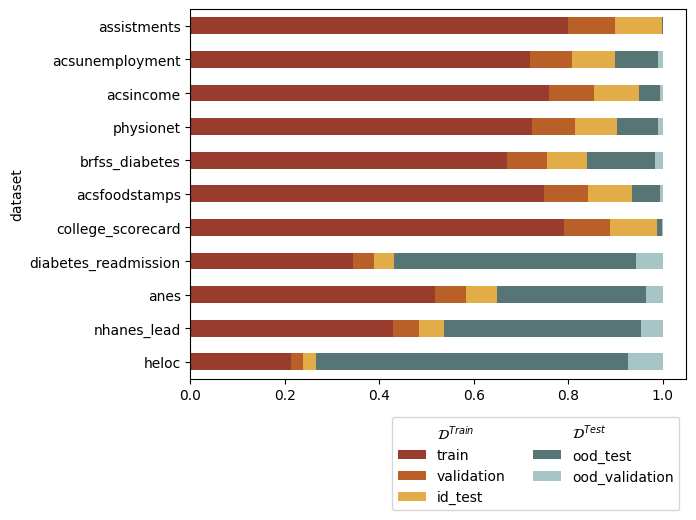

In [86]:

ax = df_sizes.plot(x='dataset', y=splits, kind='barh', stacked=True, cmap=cmap)
h,l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[:1] + h[:3] + ph[1:] + h[3:]
labels = ["$\mathcal{D}^{Train}$"] + l[:3] + ["$\mathcal{D}^{Test}$"] + l[3:]
leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=(1, -0.23),loc='center right')
plt.show()

In [96]:
warnings.filterwarnings("ignore")

pipe = make_pipeline(
    StandardScaler(), 
    KBinsDiscretizer(#strategy='kmeans',
                    encode="onehot",
                    subsample=int(2e6))
    )

# pipe = KBinsDiscretizer(encode="onehot")


for d in df_sizes['dataset']:
    if d not in ['nhanes_lead','diabetes_readmission','college_scorecard','csfoodstamps','brfss_diabetes','physionet','anes']:
        dset = get_dataset(
            name=d, 
            cache_dir='../tableshift/tmp', 
            use_cached=True
            )

        X, y, _, _ = dset.get_pandas('train')
        X_train = pipe.fit_transform(X)
        classifier = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                        n_estimators=500, max_features="sqrt", 
                                        n_jobs=-1, random_state=2)
        classifier.fit(X_train, y)
        fi = np.copy(classifier.feature_importances_)
        print(f'{d}:')
        for s in ['id_test', 'ood_test']:
            X_, y_, _, _ = dset.get_pandas(s)
            X_test = pipe.transform(X_).toarray()
            ms = classifier.sufficiency_based_feature_importances(X_test)
            y_hat = classifier.predict(X_test)
            roc = accuracy_score(y_, y_hat)
            if not np.any(np.isnan(fi)):
                cls_fi = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                            n_estimators=500, max_features="sqrt", 
                                            n_jobs=-1, random_state=2, 
                                            biased_subspaces=True, feature_bias=fi)
                cls_fi.fit(X_train, y)
                y_fi = cls_fi.predict(X_test)
                roc_fi = accuracy_score(y_, y_fi)
            else:
                roc_fi = -1

            if not np.any(np.isnan(ms)):
                cls_ms = UDBaggingClassifier(base_estimator=InterpretableBernoulliNB(binarize=0.5),
                                        n_estimators=500, max_features="sqrt", 
                                        n_jobs=-1, random_state=2, 
                                        biased_subspaces=True, feature_bias=ms)
                cls_ms.fit(X_train, y)
                y_ms = cls_ms.predict(X_test)
                roc_ms = accuracy_score(y_, y_ms)
            else:
                roc_ms = -1
        
            print(f'   {s}: bl: {roc:.03f} \t fi: {roc_fi:.03f} \t ms: {roc_ms:.03f}')

SyntaxError: invalid syntax (485299225.py, line 14)

- FAzer um pseudo codigo de como obter 
- treina o modelo naase A
- treina o modelo na base b
- obtem 
- disponibiizar as fórmulas completas


descobrir o que os que



alta interdependencia em redes neurais

<Axes: ylabel='dataset'>

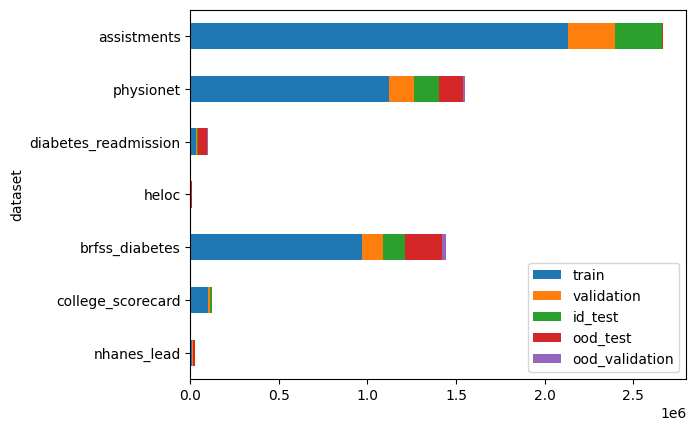

In [10]:
pd.DataFrame(sizes).plot(kind='barh', stacked=True, x = 'dataset')

<AxesSubplot:>

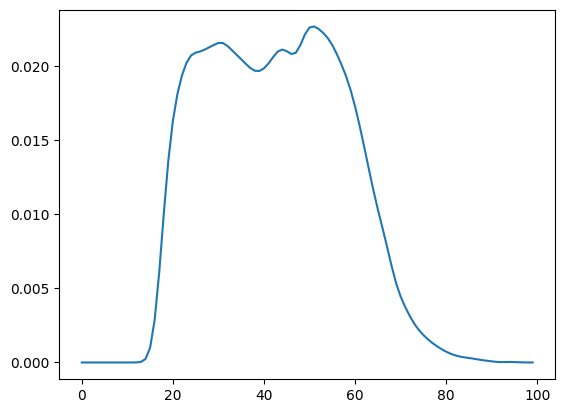

In [38]:
import scipy.stats as stats

# create a kde distribution from X.Age
kde = stats.gaussian_kde(X.Age, bw_method="scott")

# get a likelihood from 16 to 90
pd.Series(kde.pdf(np.arange(0, 100))).plot()


In [1]:
import pandas as import pd
import os
import ipdb

df = pd.read_csv(os.path.join(
    self.cache_dir,
    self.kaggle_dataset_name,
    "2012-2013-data-with-predictions-4-final.csv"))

ipdb.set_trace()
df[tableshift.datasets.ASSISTMENTS_FEATURES.names].to_feather(
    os.path.join(self.cache_dir, "assistments-subset.feather"))

NameError: name 'pd' is not defined